In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import time
import pickle

# cells defined in earlier notebooks

In [2]:
def R_nonbinding_3eq(y,t):
    """
    system of ODEs from Zaytsev 2016, simplified using two mass balances
    with the following components:
    - a: inactive Aurora B kinase
    - A: active Aurora B kinase
    - AA: enzyme-substrate complex of inactive + active Aurora B kinase
    - Ph: phosphatase
    - PhA: enzyme-substrate complex of phosphatase + active Aurora B kinase
    - a0: total Aurora B kinase
    - p0: total phosphatase
    """
    # set variable space
    A, AA, Ph = y
    
    # mass balances
    PhA = p0 - Ph
    a = a0 - A - 2*AA - PhA
    
    # reaction equations
    dAdt = (kcis - kfa*A)*a + (kra+2*kca)*AA - kfp*A*Ph + krp*PhA
    dAAdt = kfa*A*a - (kra+kca)*AA
    dPhdt = -kfp*A*Ph + (krp + kcp)*PhA
    
    return dAdt, dAAdt, dPhdt

In [3]:
"""
parameters from Zaytsev 2016
"""

kcis = 7.29*10**-6    # 1/s        # rate constant for 'in cis' Aurora B activation

kfa  = 0.1            # 1/(uM*s)   # rate constant for AA complex formation
kca  = 2.7*10**-2     # 1/s        # rate constant for AA catalysis
Kma  = 51             # uM         # Michaelis constant for AA 'in trans' activation
kra  = kfa*Kma-kca    # 1/         # rate constant for AA complex dissociation

kfp  = 0.6            # 1/(uM*s)   # rate constant for PhA complex formation
kcp  = 2.4*10**-2     # 1/s        # rate constant for PhA catalysis
Kmp  = 1.95           # uM         # Michaelis constant for PhA 'in trans' activation
krp  = kfp*Kmp-kcp    # 1/s        # rate constant for PhA complex dissociation

In [4]:
"""
algorithm to find high + low steady states 
for different phosphatase concentrations + 10 uM total kinase
uses zero for the low state in phosphatase concentrations with monostable high states
to be used as initial active kinase concentrations for spatial simulations
"""
t = np.linspace(0,2000*60,2000*60)

a0 = 10

# build phosphatase concentration list
p0_range = [0,.2]
for n in np.arange(.4,.61,.01):
    p0_range.append(round(n,2))

# temporal evolution to find steady state concentrations with low initial kinase activity
lo_ss_nbns = []
for p0 in p0_range:
    y = odeint(R_nonbinding_3eq,[0,0,p0],t)
    A, aA, Ph = y[-1,:]
    
    # use zero initial active kinase for points with monostable high states
    if A > 1:
        lo_ss_nbns.append((str(p0),0,a0,0,p0,0))
    else:
        PhA = p0 - Ph
        a = a0-A-2*aA-PhA
        lo_ss_nbns.append((str(p0),A, a, aA, Ph, PhA))

# temporal evolution to find steady state concentrations with high initial kinase activity
hi_ss_nbns = []
for p0 in p0_range:
    y = odeint(R_nonbinding_3eq,[a0,0,p0],t)
    A, aA, Ph = y[-1,:]
    PhA = p0 - Ph
    a = a0-A-2*aA-PhA
    hi_ss_nbns.append((str(p0),A, a, aA, Ph, PhA))

In [5]:
def mesh_fourier(zmin,zmax,nz):
    """
    discrete approximation of the spatial derivative operator (Laplacian)
    uses spectral symmetry to simplify operations, forces periodic boundary conditions
    """
    dz = np.zeros((nz,nz))
    for i in range(nz):
        for j in range(nz):
            if i == j:
                dz[i,i] = 0
            else:
                dz[i,j] = np.pi*(-1)**((i-1)+(j-1))/(zmax-zmin)/np.tan(((i-1)-(j-1))*np.pi/(nz))
    return dz

In [6]:
def R_nonbinding_5eq(y,t):
    """
    system of ODEs from Zaytsev 2016, without simplifications
    """
    # unpack species profiles
    A, a, aA, Ph, PhA = y

    # calculate reaction equations
    dadt = -(kcis + kfa*A)*a + kra*aA + kcp*PhA
    dAdt = (kcis - kfa*A)*a + (kra + 2*kca)*aA - kfp*A*Ph + krp*PhA
    daAdt = kfa*A*a - (kra + kca)*aA 
    dPhdt = -kfp*A*Ph + (krp + kcp)*PhA
    dPhAdt = -dPhdt
    
    # output concentration changes
    return dAdt, dadt, daAdt, dPhdt, dPhAdt

In [7]:
def spatial_simulation_nonbind_ss_perturb(lo_ss,hi_ss,t_end,dt,t_save,L,N,perturb_width):
    """
    reaction-diffusion algorithm with a perturbed center width as initial conditions
    combines the above kinase-phosphatase reaction network + simple diffusion algorithm
    """
    # extract the information from the initial condition array function inputs
    lostr, A0_lo, a0_lo, aA0_lo, Ph0_lo, PhA0_lo = lo_ss
    histr, A0_hi, a0_hi, aA0_hi, Ph0_hi, PhA0_hi = hi_ss
    
    # initilize perturbed conditions for each reacting species
    A = np.ones(N)*A0_lo
    A[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*A0_hi
    a = np.ones(N)*a0_lo
    a[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*a0_hi
    aA = np.ones(N)*aA0_lo
    aA[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*aA0_hi
    Ph = np.ones(N)*Ph0_lo
    Ph[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*Ph0_hi
    PhA = np.ones(N)*PhA0_lo
    PhA[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*PhA0_hi
    
    # combine species profiles into a single variable
    y = A, a, aA, Ph, PhA
    
    A_arr = np.zeros((N,round(t_end/t_save)+1))
    t_vec = np.zeros(round(t_end/t_save)+1)
    
    A_arr[:,0] = A
    
    dz = mesh_fourier(0,L,N)
    dz2 = np.dot(dz,dz)
    
    counter = 0
    counter_save = 0
    t = 0
    
    for i in range(round(t_end/dt)+1):
        counter += 1
        
        # solve reaction equations
        dy = R_nonbinding_5eq(y,t)
        
        # evolve species profiles according to reaction + diffusion
        A += dt*( dy[0] + D*np.dot(dz2,A) )   # dA/dt = R(A,a,aA,Ph,PhA) + D * dA^2/dz^2
        a += dt*( dy[1] + D*np.dot(dz2,a) )
        aA += dt*( dy[2] + D*np.dot(dz2,aA) )
        Ph += dt*( dy[3] + D*np.dot(dz2,Ph) )
        PhA += dt*( dy[4] + D*np.dot(dz2,PhA) )
        
        y = A, a, aA, Ph, PhA
        
        t += dt
        
        if counter == round(t_save/dt):
            counter = 0
            counter_save += 1
            
            A_arr[:,counter_save] = A
            t_vec[counter_save] = t
        
        arrays = A_arr,t_vec
        y = A, a, aA, Ph, PhA
    
    # output saved data arrays + last concentration profile variable in case extension is desired
    return arrays, y

# effect of diffusion speed on traveling front behavior

In [15]:
"""
parameters used for the set of simulations below
"""
Ds = [
    10**-2,
    10**-3,
    10**-4,
    10**-5,
    10**-6,
    10**-7,
    10**-8
]

t_ends = [
    60*60,
    160*60,
    260*60,
    600*60,
    1000*60,
    1000*60,
    1000*60
]

dts = [
    0.025,
    0.1,
    0.25,
    0.25,
    0.25,
    0.25,
    0.25
]

t_save = 60

N = 480
L = 20
x_span = np.linspace(-L/2,L/2,N)

In [13]:
"""
simulates set of ~1.7 um perturbations with 0.55 uM phosphatase + varying diffusion coefficients
- perturbation width chosen to be identical to the chromosomal binding profile width
"""
start = time.time()
## algorithm takes ~16 min

# actual simulated perturbation width = (pw+1) * L / (N-1) = 9*500/399 ~ 11.3 um
pw = 40
print(f'actual pw: {round(x_span[int(N/2+pw/2)]*2,1)} um')

# phosphatase concentration: 0.55 uM
idx = 17
print(f'P = {lo_ss_nbns[idx][0]} uM')

perturbs_P055_varyDs = []
for D,t_end,dt in zip(Ds,t_ends,dts):
    print(f'D: {D:.0E} um^2/sec')
    arrays, y = spatial_simulation_nonbind_ss_perturb(lo_ss_nbns[idx],hi_ss_nbns[idx],t_end,dt,t_save,L,N,pw)
    perturbs_P055_varyDs.append(arrays)
    
pickle.dump(perturbs_P055_varyDs,open('perturbs_P055_varyDs','wb'))

end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

actual pw: 1.7 um
P = 0.55 uM
D: 1E-02 um^2/sec
D: 1E-03 um^2/sec
D: 1E-04 um^2/sec
D: 1E-05 um^2/sec
D: 1E-06 um^2/sec
D: 1E-07 um^2/sec
D: 1E-08 um^2/sec
~ 15.8 min


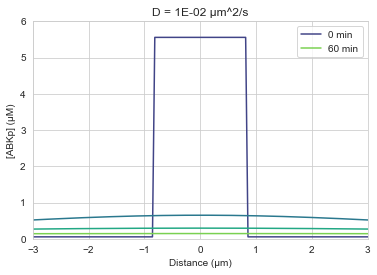

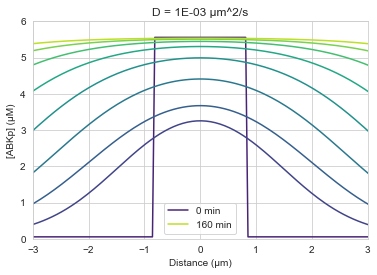

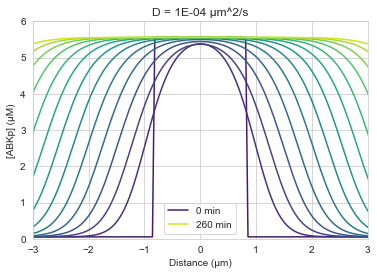

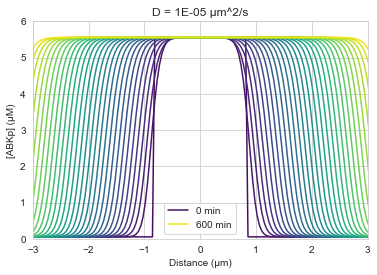

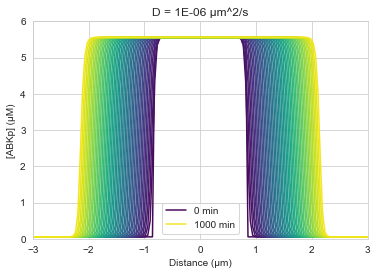

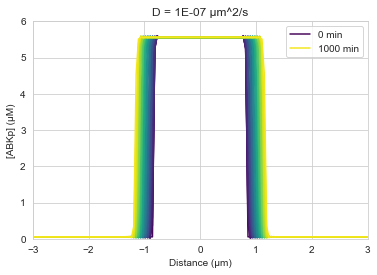

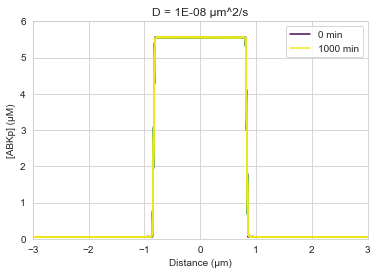

In [16]:
"""
Figure 14 + Supplemental 16
plots simulation results with a 20 min separation between each spatial profile
- D: 1E-02 um^2/s : no traveling front develops
- D: 1E-03 um^2/s : wide traveling front develops
- traveling front narrows/sharpens/slows as diffusion speed increases
- D: 1E-08 um^2/s : front is effectively stationary
"""

perturbs_P055_varyDs = pickle.load(open('perturbs_P055_varyDs','rb'))

for arrays,D,t_end in zip(perturbs_P055_varyDs,Ds,t_ends):

    A_arr, t_vec = arrays

    lin_range = range(0,int(t_end/60+1),20)
    colors = sns.color_palette('viridis', n_colors=len(lin_range))

    for n,i in enumerate(lin_range):
        # send first + last spatial profiles to the legend
        if i == 0 or i == lin_range[-1]:
            plt.plot(x_span,A_arr[:,i],color=colors[n], label=f'{i} min')
        else:
            plt.plot(x_span,A_arr[:,i],color=colors[n])
    plt.xlabel("Distance (\u03BCm)")
    plt.ylabel("[ABKp] (\u03BCM)")
    plt.title(f'D = {D:.0E} \u03BCm^2/s')
    plt.ylim(0,6)
    plt.xlim(-3,3)
    plt.legend()
    plt.show()

# traveling front + localization behavior with reduced diffusion speed

In [6]:
def R_binding(y):
    """
    system of ODEs from Zaytsev 2016 where kinase binding to sites along a chromosome is included,
    previously defined a/A/aA/PhA components involve a diffusible/unbound Aurora B kinase,
    the following components are introduced in this model:
    - b: inactive/bound Aurora B kinase
    - B: active/bound Aurora B kinase
    - aB/bA/bB: enzyme-substrate complexes of inactive/active/bound/diffusible Aurora B kinase
    - PhB: enzyme-substrate complex of phosphatase + active/bound Aurora B kinase
    - BS: free binding sites
    """
    A, B, a, b, aA, aB, bA, bB, Ph, PhA, PhB, BS = y

    dAdt = (kcis - kfa*A)*a + (kra + 2*kca)*aA - kfp*A*Ph + krp*PhA +\
        kca*aB - kfa*A*b + (kra + kca)*bA + koff*B - kon*BS*A
    
    dBdt = (kcis - kfb*B)*b + (krb + 2*kca)*bB - kfp*B*Ph + krp*PhB +\
        kca*bA - kfa*B*a + (kra + kca)*aB - koff*B + kon*BS*A
    
    dadt = -(kcis + kfa*A + kfa*B)*a + kra*(aA + aB) + kcp*PhA + koff*b - kon*BS*a
    dbdt = -(kcis + kfb*B + kfa*A)*b + krb*bB + kra*bA + kcp*PhB - koff*b + kon*BS*a
    
    daAdt = kfa*a*A - (kra + kca)*aA
    daBdt = kfa*a*B - (kra + kca)*aB
    dbAdt = kfa*b*A - (kra + kca)*bA
    dbBdt = kfb*b*B - (krb + kca)*bB
    
    dPhdt = -kfp*Ph*(A + B) + (krp + kcp)*(PhA + PhB)
    dPhAdt = kfp*Ph*A - (krp + kcp)*PhA
    dPhBdt = kfp*Ph*B - (krp + kcp)*PhB
    
    return dAdt, dBdt, dadt, dbdt, daAdt, daBdt, dbAdt, dbBdt, dPhdt, dPhAdt, dPhBdt

In [9]:
"""
additional parameters for the binding model 
previously defined parameters for the nonbinding model still apply
"""
# sterically limited b*B in trans autoactivation
kfb   = kfa * 0.01      # 1/(uM*s)
Kmb   = Kma * 100       # uM
kra   = kfa*Kma-kca     # 1/s
krb   = kfb*Kma-kca     # 1/s

# rate constants for kinase binding + dissociating from binding sites
kon = 2.9                # 1/(uM*s)
koff = 0.014             # 1/s

In [7]:
def spatial_simulation_binding(A0,Atot,P0,t_end,dt,t_save,L,N,BSmin,BSw):
    """
    reaction-diffusion algorithm with added binding/localization reactions
    available chromosomal binding sites are situated in a Gaussian-like distribution
    initial kinase/phosphatase conditions are constant across domain
    """
    # initilize conditions for each reacting species
    # flat initial kinase + phosphatase profiles
    A = np.zeros(N) + A0
    B = np.zeros(N)
    a = np.zeros(N) + Atot - A
    b = np.zeros(N)
    aA = np.zeros(N)
    aB = np.zeros(N)
    bA = np.zeros(N)
    bB = np.zeros(N)
    Ph = np.zeros(N) + P0
    PhA = np.zeros(N)
    PhB = np.zeros(N)
    
    x = np.linspace(-L/2, L/2, N)
    
    # initialize binding site profile as a Gaussian distribution 
    BS0 = (Atot - BSmin) * np.exp(- Atot / BSw * x**2) + BSmin
    
    y = A, B, a, b, aA, aB, bA, bB, Ph, PhA, PhB, BS0
    
    A_arr = np.zeros((N,round(t_end/t_save)+1))
    B_arr = np.zeros((N,round(t_end/t_save)+1))
    a_arr = np.zeros((N,round(t_end/t_save)+1))
    b_arr = np.zeros((N,round(t_end/t_save)+1))
    aA_arr = np.zeros((N,round(t_end/t_save)+1))
    aB_arr = np.zeros((N,round(t_end/t_save)+1))
    bA_arr = np.zeros((N,round(t_end/t_save)+1))
    bB_arr = np.zeros((N,round(t_end/t_save)+1))
    Ph_arr = np.zeros((N,round(t_end/t_save)+1))
    PhA_arr = np.zeros((N,round(t_end/t_save)+1))
    PhB_arr = np.zeros((N,round(t_end/t_save)+1))
    BS_arr = np.zeros((N,round(t_end/t_save)+1))
    t_vec = np.zeros(round(t_end/t_save)+1)
    
    # pulls non-zero concentration profiles to the saved data arrays
    A_arr[:,0] = A
    a_arr[:,0] = a
    Ph_arr[:,0] = Ph
    BS_arr[:,0] = BS0
    
    dz = mesh_fourier(0,L,N)
    dz2 = np.dot(dz,dz)
    
    counter = -1
    counter_save = 0
    t = 0
    
    for i in range(round(t_end/dt)+1):
        counter += 1
        
        dy = R_binding(y)
        
        A += dt*(dy[0] + D*np.dot(dz2,A))
        B += dt*dy[1]
        a += dt*(dy[2] + D*np.dot(dz2,a))
        b += dt*dy[3]
        aA += dt*(dy[4] + D*np.dot(dz2,aA))
        aB += dt*dy[5]
        bA += dt*dy[6]
        bB += dt*dy[7]
        Ph += dt*(dy[8] + D*np.dot(dz2,Ph))
        PhA += dt*(dy[9] + D*np.dot(dz2,PhA))
        PhB += dt*dy[10]
        
        # calculate binding site profile via mass balance
        BS = BS0 - B - b - aB - bA - 2*bB - PhB
        
        y = A, B, a, b, aA, aB, bA, bB, Ph, PhA, PhB, BS
        
        t += dt
        
        if counter == round(t_save/dt):
            counter = 0
            counter_save += 1
            
            A_arr[:,counter_save] = A
            B_arr[:,counter_save] = B
            a_arr[:,counter_save] = a
            b_arr[:,counter_save] = b
            aA_arr[:,counter_save] = aA
            aB_arr[:,counter_save] = aB
            bA_arr[:,counter_save] = bA
            bB_arr[:,counter_save] = bB
            Ph_arr[:,counter_save] = Ph
            PhA_arr[:,counter_save] = PhA
            PhB_arr[:,counter_save] = PhB
            BS_arr[:,counter_save] = BS
            t_vec[counter_save] = t
    
    arrays = A_arr, B_arr, a_arr, b_arr, aA_arr, aB_arr, bA_arr, bB_arr, Ph_arr, PhA_arr, PhB_arr, BS_arr, t_vec
    y = A, B, a, b, aA, aB, bA, bB, Ph, PhA, PhB, BS
    
    return arrays, y

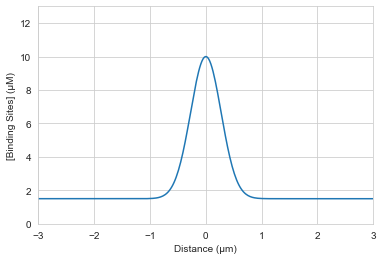

In [17]:
"""
constructs/plots kinase chromosomal binding site profile to be used for simulations below
"""

N = 500
L = 10
x_span = np.linspace(-L/2,L/2,N)

# scales initial binding site profile to approximate Figure 6 - Supplement 1C, Zaytsev, 2016
Atot = 10
BSmin = 1.5
BSw = 1.5

BS0 = (Atot - BSmin) * np.exp(- Atot / BSw * x_span**2) + BSmin

plt.plot(x_span,BS0)
plt.ylim(0,13)
plt.xlim(-3,3)
plt.ylabel('[Binding Sites] (\u03BCM)')
plt.xlabel('Distance (\u03BCm)');

In [ ]:
"""
parameters for the simulation below
"""
Ds = [
    10**-4,
    10**-5,
    10**-6
]

t_end = 2000*60
dt = 0.035
t_save = 60

A0 = 0
P0 = 0.55

In [19]:
"""
simulates reaction/diffusion/localization with 0.55 uM phosphatase + varying diffusion coefficients
total kinase kept at 10 uM across domain length, initial active kinase at zero
binding site profile used is plotted above
"""
start = time.time()
## algorithm takes >2 hrs

bindingsims_P055_varyDs = []
for D in Ds:
    print(f'D: {D:.0E} um^2/sec')
    arrays, y = spatial_simulation_binding(A0,Atot,P0,t_end,dt,t_save,L,N,BSmin,BSw)
    bindingsims_P055_varyDs.append(arrays)
    
pickle.dump(bindingsims_P055_varyDs,open('bindingsims_P055_varyDs','wb'))

end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

D: 1E-04 um^2/sec
D: 1E-05 um^2/sec
D: 1E-06 um^2/sec
~ 131.5 min


D: 1E-04 um^2/sec


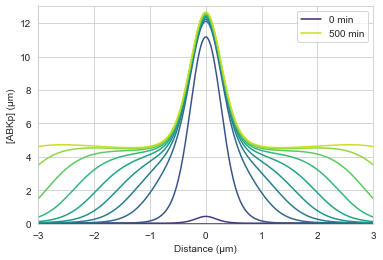

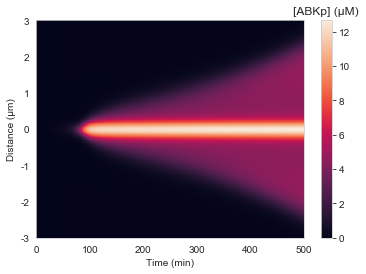

D: 1E-05 um^2/sec


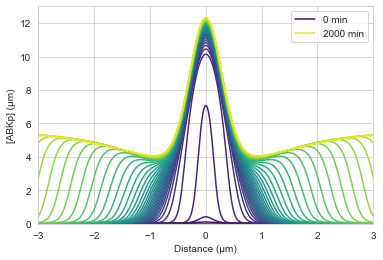

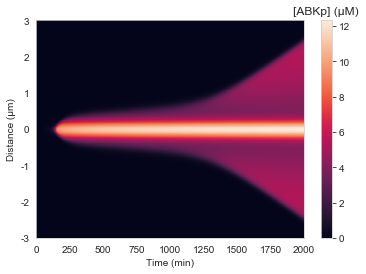

D: 1E-06 um^2/sec


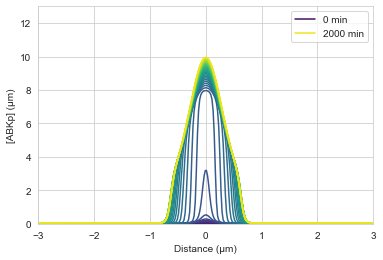

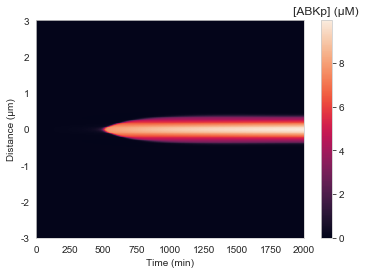

In [20]:
"""
Figure 15 + Supplemental Figure 17
plots simulation results in two ways:
- time evolution of spatial profiles with a 50 min separation between profiles
- spatiotemporal heatmap

- D: 1E-04 um^2/s
    - localization force towards the Gaussian peak in the center of the chromosome pulls kinase, 
    concentrating active kinase until autoactivation
    - linearly progressing traveling front develops outward along chromosomes
- D: 1E-05 um^2/s
    - stalling behavior emerges between autoactivation + traveling front progression
        - shown by the increased density in spatial profiles at the centromere's boundaries
        - shown also in the heatmap by the shallow slope around 250 - 1250 minutes
        - represents a transient minimum in net force behind traveling front
- D: 1E-06 um^2/s
    - autoactivation but no traveling front develops, pinned to the chromosomal binding sites
"""

bindingsims_P055_varyDs = pickle.load(open('bindingsims_P055_varyDs','rb'))

# first simulation limited to first 500 min
t_ends = [
    500,
    2000,
    2000
]

for arrays,D,t_end in zip(bindingsim_P055_varyDs,Ds,t_ends):
    print(f'D: {D:.0E} um^2/sec')
    
    A_arr, B_arr, a_arr, b_arr, aA_arr, aB_arr, bA_arr, bB_arr, Ph_arr, PhA_arr, PhB_arr, BS_arr, t_vec = arrays

    lin_range = range(0,t_end+1,50)
    colors = sns.color_palette('viridis', n_colors=len(lin_range))

    for n,i in enumerate(lin_range):
        if i == 0 or i == t_end:
            plt.plot(x_span, A_arr[:,i]+B_arr[:,i], color=colors[n], label=f'{i} min')
        else: 
            plt.plot(x_span, A_arr[:,i]+B_arr[:,i], color=colors[n])
    plt.ylim(0,13)
    plt.xlim(-3,3)
    plt.ylabel('[ABKp] (\u03BCm)')
    plt.xlabel('Distance (\u03BCm)')
    plt.legend()
    plt.show()
    
    # uses pcolormesh() to plot spatial profiles along the y-axis, evolving through time on the x-axis
    heatmap = plt.pcolormesh(A_arr[:,:t_end]+B_arr[:,:t_end])
    cbar = plt.colorbar(heatmap)
    cbar.ax.set_title('[ABKp] (\u03BCM)')
    # changes tich marks from spatial discretization points to distance in micrometers
    plt.yticks(np.linspace(0,500,7), np.arange(-3, 4, 1))
    plt.ylabel('Distance (\u03BCm)')
    plt.xlabel('Time (min)')
    plt.show()